In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [9]:
len(ds_train)

42876

## Networks

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1))
        self.activation = nn.LeakyReLU(0.2)
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        return out + x
    
class UpsampleBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv = nn.utils.spectral_norm(nn.Conv2d(nf, nf * 4, kernel_size=3, stride=1, padding=1))
        self.upsample = nn.PixelShuffle(2)
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.activation(out)
        return out

In [11]:
class GeneratorNoisy(nn.Module):
    def __init__(self, nres, nf_in, nf, relu_out=False):
        super().__init__()
        self.conv_in = nn.utils.spectral_norm(nn.Conv2d(nf_in, nf-1, kernel_size=9, stride=1, padding=4))
        self.activation_in = nn.LeakyReLU(0.2)
        self.resblocks = nn.Sequential(*[
            ResidualBlock(nf) for i in range(nres)
        ])
        self.upblocks = nn.Sequential(*[
            UpsampleBlock(nf) for i in range(3)
        ])
        self.conv_out = nn.utils.spectral_norm(nn.Conv2d(nf, 1, kernel_size=9, stride=1, padding=4))
        self.relu_out = relu_out
        
    def forward(self, x):
        out = self.conv_in(x)
        out = self.activation_in(out)
        bs, _, h, w = x.shape
        z = torch.normal(0, 1, size=(bs, 1, h, w), device=device, requires_grad=True)
        out = torch.cat([out, z], dim=1)
        skip = out
        out = self.resblocks(out)
        out = out + skip
        out = self.upblocks(out)
        out = self.conv_out(out)
        if self.relu_out:
            out = nn.functional.relu(out)
        return out

In [12]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, nf_in, nf_out, stride, batch_norm=True):
        super().__init__()
        layers = []
        layers.append(nn.utils.spectral_norm(nn.Conv2d(nf_in, nf_out, kernel_size=3, stride=stride, padding=1)))
        if batch_norm:
            layers.append(nn.BatchNorm2d(nf_out))
        layers.append(nn.LeakyReLU(0.2))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class cDiscriminatorUpsample(nn.Module):
    def __init__(self, nfs, batch_norm=True, in_size=128, sigmoid=True):
        super().__init__()
        self.sigmoid = sigmoid
        
        # Upsample
        self.upsample = nn.Upsample(scale_factor=8, mode='nearest')
        
        # First layer
        self.first_layer = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(2, nfs[0], kernel_size=3, padding=1)),
            nn.LeakyReLU(0.2),
            DiscriminatorBlock(nfs[0], nfs[0], stride=2, batch_norm=batch_norm)
        )
        
        # Intermediate layers
        int_layers = []
        for nf_in, nf_out in zip(nfs[:-1], nfs[1:]):
            int_layers.extend([
                DiscriminatorBlock(nf_in, nf_out, stride=1, batch_norm=batch_norm),
                DiscriminatorBlock(nf_out, nf_out, stride=2, batch_norm=batch_norm),
            ])
        self.int_layers = nn.Sequential(*int_layers)
        
        # Final layers
        out_size = (in_size // 2**len(nfs))**2 * nfs[-1]
        print('Size after convolutions', out_size)
        self.final_layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(out_size, 256)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )
            
        
    def forward(self, x):
        lr, hr = x
        x = torch.cat([hr, self.upsample(lr)], dim=1)
        out = self.first_layer(x)
        out = self.int_layers(out)
        out = out.view(out.shape[0], -1)   # Flatten
        out = self.final_layers(out)
        if self.sigmoid:
            out = torch.functional.sigmoid(out)
        return out

## Trainer

In [13]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm -1)**2)
    #### END CODE HERE ####
    return penalty

In [14]:
def get_gradient(crit, X, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit([X, mixed_images])
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [15]:
class WGANTrainer():
    """Implements a Keras-style fit function and tracks train/valid losses"""
    def __init__(self, gen, disc, gen_optimizer, disc_optimizer,  dl_train, dl_valid=None, 
                 valid_every_epochs=1, disc_repeats=1, gen_repeats=1,
                 gp_lambda=None, l_loss=None, l_lambda=20,
                 save_dir=None, plot=False):
        self.gen = gen
        self.disc = disc
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.valid_every_epochs = valid_every_epochs
        self.criterion = nn.BCELoss()
        if l_loss == 'l1':
            self.l_loss = nn.L1Loss()
        elif l_loss == 'l2':
            self.l_loss = nn.MSELoss()
        else:
            self.l_loss = None
        self.l_lambda = l_lambda
        self.disc_repeats = disc_repeats
        self.gen_repeats = gen_repeats
        self.gp_lambda = gp_lambda
        self.save_dir = save_dir
        self.plot = plot
        
        self.epoch = 0
        self.train_gen_losses = []
        self.train_mse = []
        self.train_disc_losses = []
        self.train_epochs = []
#         self.valid_losses = []
#         self.valid_epochs = []
        
    def fit(self, epochs):

        # Epoch loop
        for epoch in range(1, epochs+1):

            prog_bar = tqdm.tqdm(total=len(self.dl_train), desc=f'Epoch {epoch}')
            train_loss, valid_loss = 0, 0

            # Train
            for i, (X, y) in enumerate(self.dl_train):
                X = X.to(device); real = y.to(device)
                bs = X.shape[0]
                
                mean_disc_loss = 0
                for _ in range(self.disc_repeats):
                    # Train discriminator
                    self.disc_optimizer.zero_grad()

                    fake = self.gen(X)
                    preds_real = self.disc([X, real])
                    preds_fake = self.disc([X, fake.detach()])
                    
                    disc_loss = -torch.mean(preds_real) + torch.mean(preds_fake)
                    
                    if self.gp_lambda:
                        epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                        gradient = get_gradient(disc, X, real, fake.detach(), epsilon)
                        gp = gradient_penalty(gradient)
                        disc_loss += self.gp_lambda * gp
                    
                    mean_disc_loss += disc_loss.item() / self.disc_repeats
                    disc_loss.backward(retain_graph=True)
                    self.disc_optimizer.step()
                
                
                # Train generator
                mean_gen_loss = 0
                mean_mse = 0
                mean_l_loss = 0
                for _ in range(self.gen_repeats):
                    self.gen_optimizer.zero_grad()

                    fake = self.gen(X)
                    preds_fake = self.disc([X, fake])

                    mse = nn.MSELoss()(fake, real).item()   # For diagnostics only

                    gen_loss = -torch.mean(preds_fake)
                    if self.l_loss:
                        l_loss = self.l_loss(fake, real)
                        gen_loss += self.l_lambda * l_loss
                    gen_loss.backward()
                    self.gen_optimizer.step()
                    
                    mean_gen_loss += gen_loss.item() / self.gen_repeats
                    mean_mse += mse / self.gen_repeats
                    mean_l_loss += l_loss.item() / self.gen_repeats


                prog_bar.update()
#                 train_gen_loss += (loss.item() - train_loss) / (i+1)
                self.train_gen_losses.append(mean_gen_loss)
                self.train_mse.append(mse)
                self.train_disc_losses.append(mean_disc_loss)
                postfix = {
                    'train_gen_loss': mean_gen_loss,
                    'train_disc_loss': mean_disc_loss,
                    'mse': mean_mse,
                }
                if self.l_loss: postfix['l_loss'] = mean_l_loss
                prog_bar.set_postfix(postfix)
            self.train_epochs.append(self.epoch)

#             if (self.epoch-1) % self.valid_every_epochs == 0:
#                 # Valid
#                 for i, (X, y) in enumerate(self.dl_valid):
#                     X = X.to(device); y = y.to(device)
#                     y_hat = self.model(X)
#                     loss = self.criterion(y_hat, y)

#                     valid_loss += (loss.cpu().detach().numpy() - valid_loss) / (i+1)
#                 self.valid_losses.append(valid_loss)
#                 self.valid_epochs.append(self.epoch)

#                 prog_bar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss}) 
#                 prog_bar.close()
        
            if self.save_dir:
                torch.save(gen.state_dict(), f'{self.save_dir}/gen_{epoch}.pt')
                torch.save(disc.state_dict(), f'{self.save_dir}/disc_{epoch}.pt')
            if self.plot:
                plot_sample(X_sample, y_sample, gen)
                plt.show()
            self.epoch += 1
        
    def plot_losses(self, plot_valid=True):
        plt.plot(self.train_epochs, self.train_losses, label='Train')
        if plot_valid: plt.plot(self.valid_epochs, self.valid_losses, label='Valid')
        plt.legend()

## Set up training

In [16]:
def plot_sample(X, y, gen, i=0):
    preds = gen(X.to(device)).detach().cpu().numpy()
    lr = X[i, 0].detach().cpu().numpy()
    hr = y[i, 0].detach().cpu().numpy()
    pred = preds[i, 0]
    
    mn = np.min([np.min(lr), np.min(hr), np.min(pred)])
    mx = np.max([np.max(lr), np.max(hr), np.max(pred)])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    im = ax1.imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
    plt.colorbar(im, ax=ax1, shrink=0.7)
    im = ax2.imshow(pred, vmin=mn, vmax=mx, cmap='gist_ncar_r')
    plt.colorbar(im, ax=ax2, shrink=0.7)
    im = ax3.imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
    plt.colorbar(im, ax=ax3, shrink=0.7)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
gen = GeneratorNoisy(nres=3, nf_in=1, nf=32, relu_out=False).to(device)
disc = cDiscriminatorUpsample([16, 16, 32, 32, 64, 64], sigmoid=False).to(device)

Size after convolutions 256


In [19]:
# gen = GeneratorNoisy(nres=3, nf_in=1, nf=16, relu_out=False).to(device)
# disc = cDiscriminatorUpsample([16, 16, 16, 32, 32, 32], sigmoid=False).to(device)

In [20]:
count_parameters(disc), count_parameters(gen)

(235841, 171599)

In [21]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [22]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [23]:
betas = (0.5, 0.999)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-5, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5, betas=betas)

In [24]:
X, y = next(iter(dl_train))

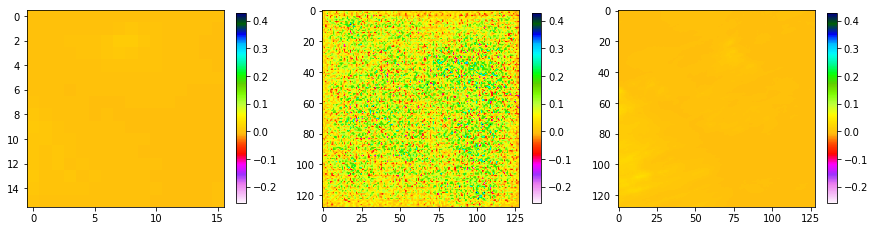

In [25]:
plot_sample(X, y, gen, 0)

In [26]:
X_sample, y_sample = X, y

## Pretraining

First attempt overfitting way too much and l1 loss dominating. Next attempt with less pretraining and a lower l_lambda

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [29]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [30]:
trainer.fit(2)

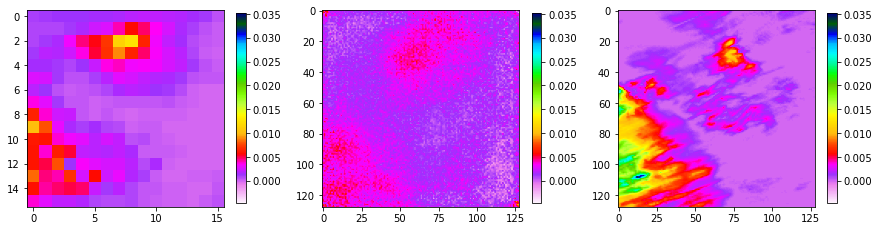

In [31]:
plot_sample(X, y, gen, 0)

## Training

In [32]:
trainer = WGANTrainer(gen, disc, gen_optimizer, disc_optimizer, dl_train, gen_repeats=2, l_loss='l1', 
                      l_lambda=5, plot=True, save_dir='../../saved_models/01-WGAN/')

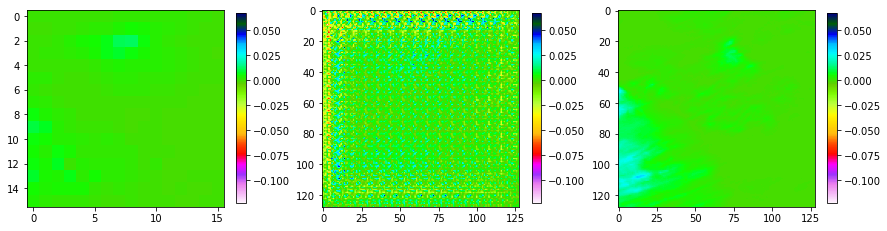

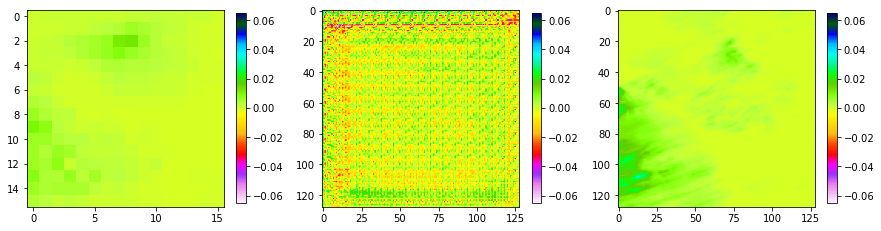

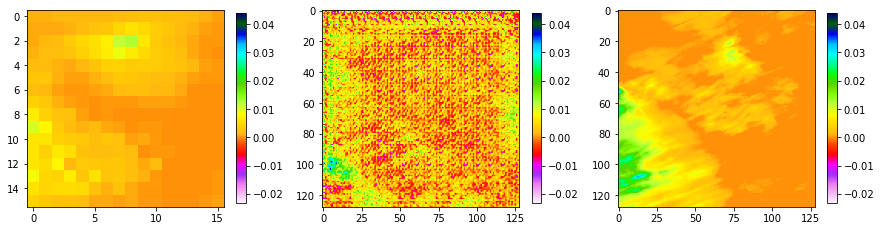

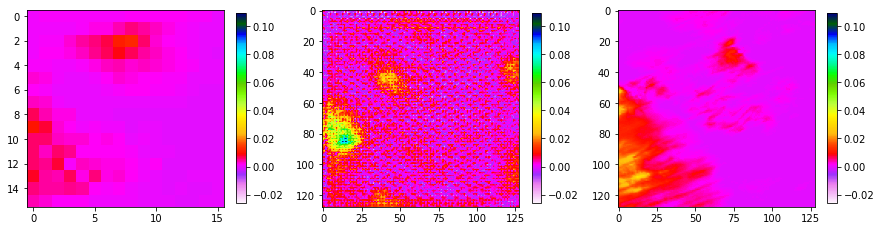

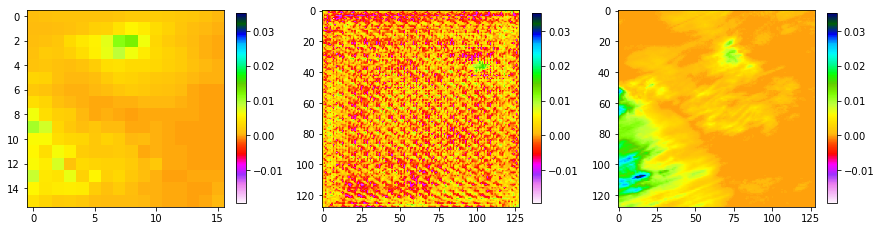

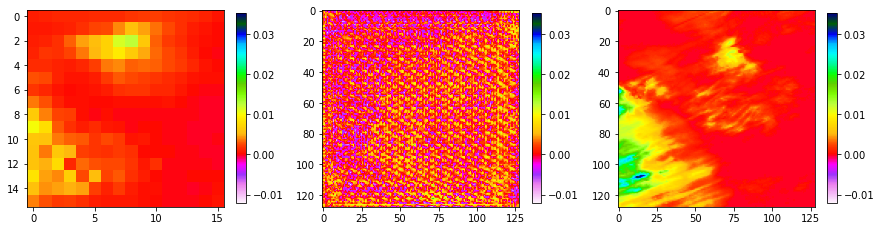

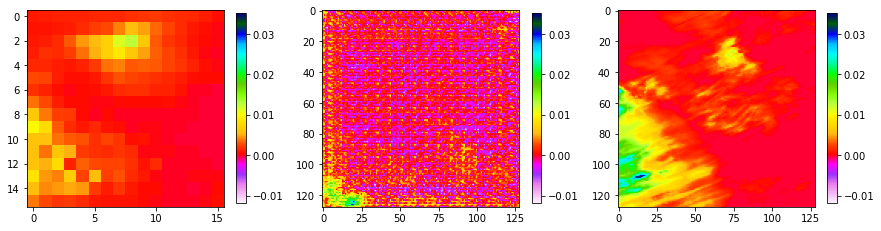

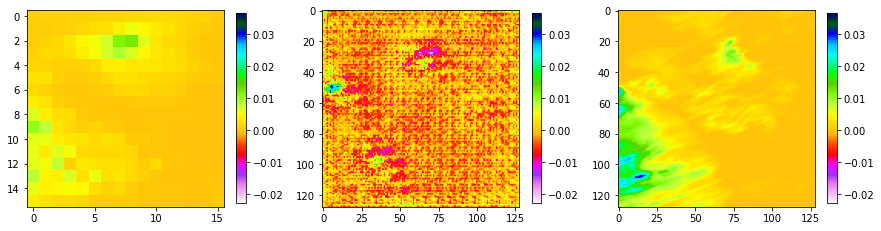

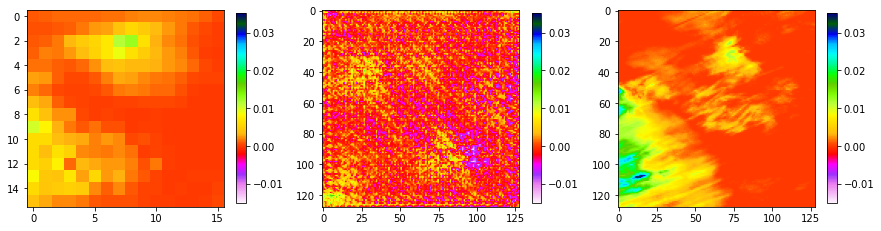

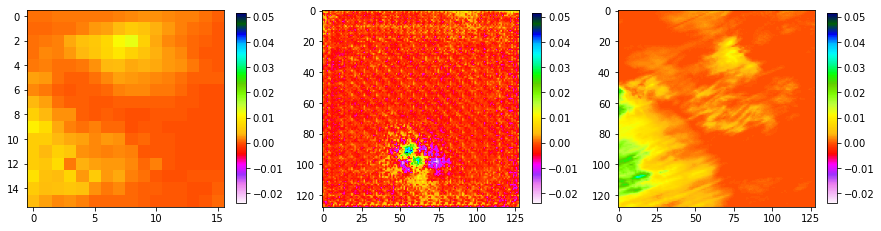

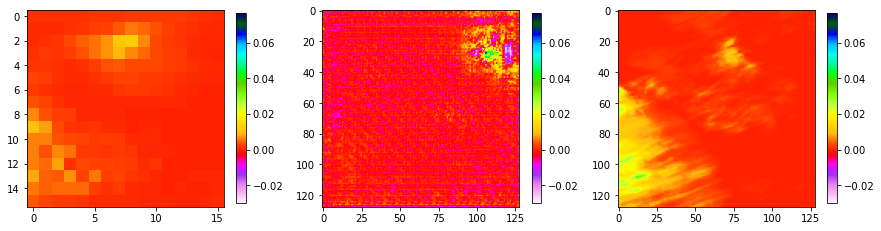

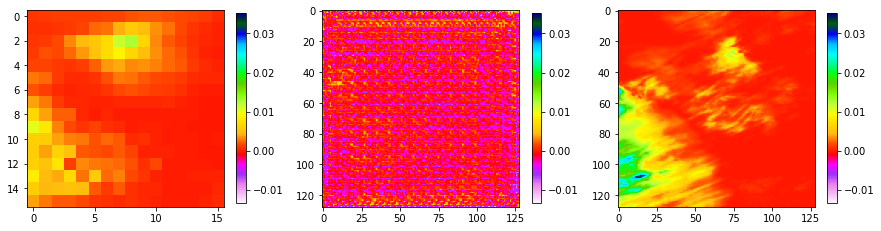

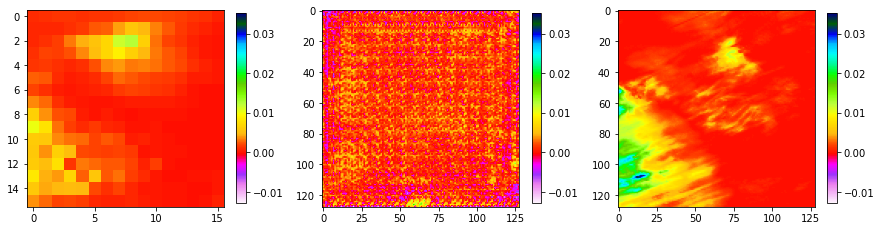

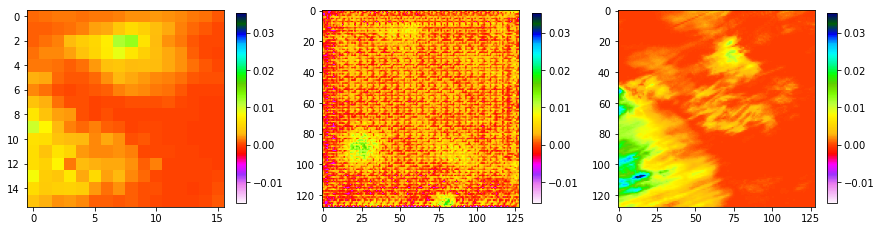

In [ ]:
trainer.fit(20)

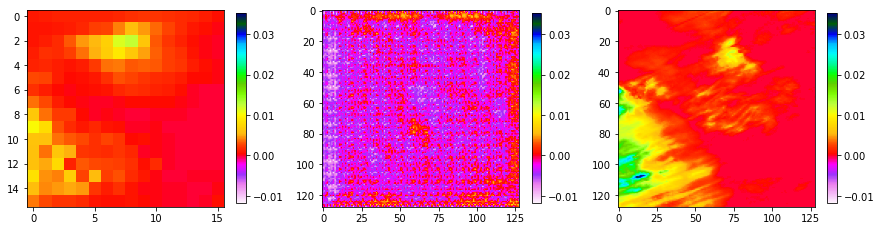

KeyboardInterrupt: 

In [35]:
trainer.fit(20)

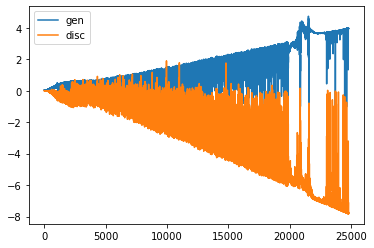

In [36]:
plt.plot(trainer.train_gen_losses, label='gen')
plt.plot(trainer.train_disc_losses, label='disc')
plt.legend()

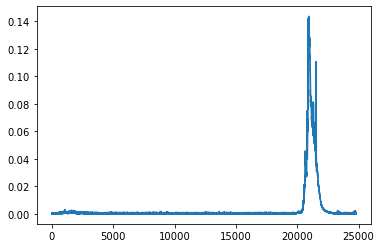

In [37]:
plt.plot(trainer.train_mse)

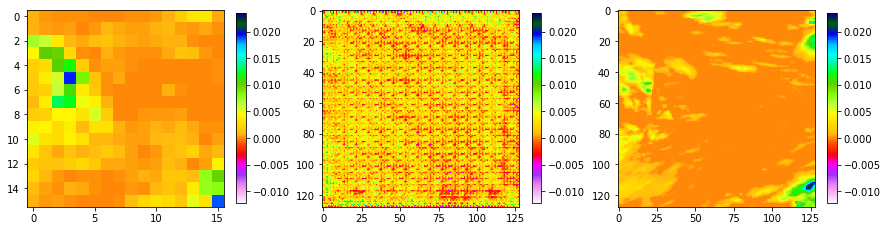

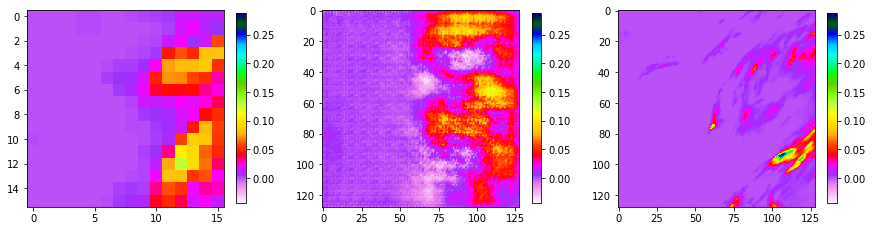

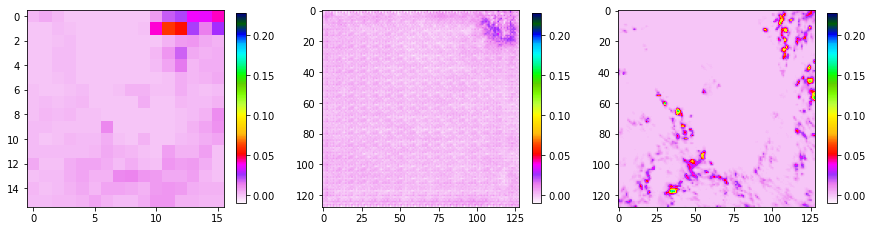

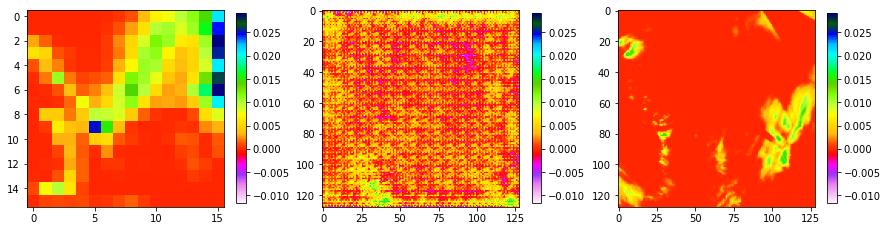

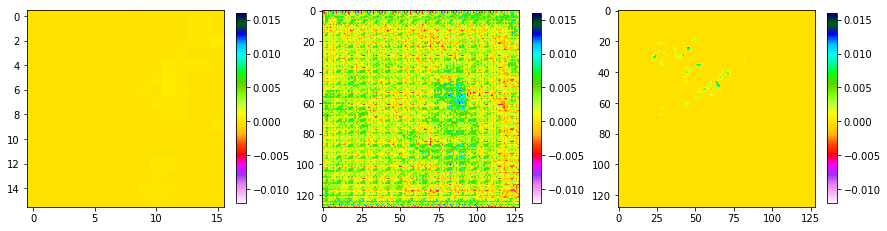

In [38]:
X, y = next(iter(dl_train))
for i in range(5):
    plot_sample(X, y, gen, i)

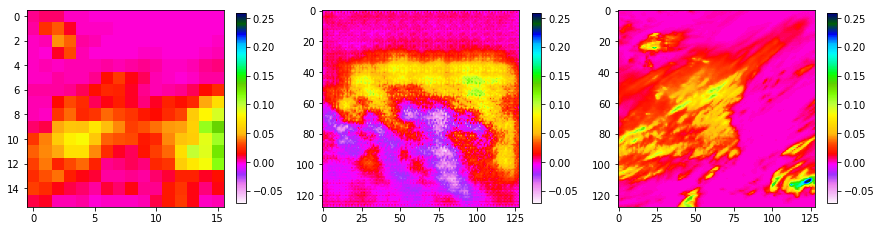

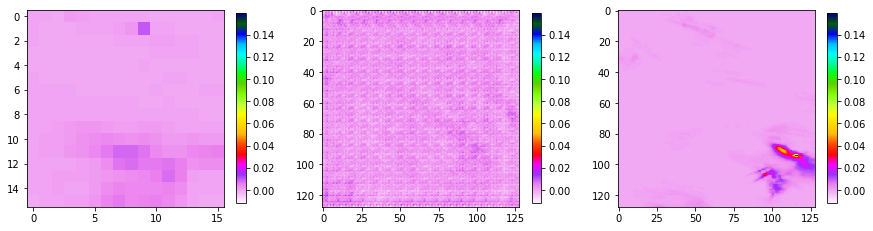

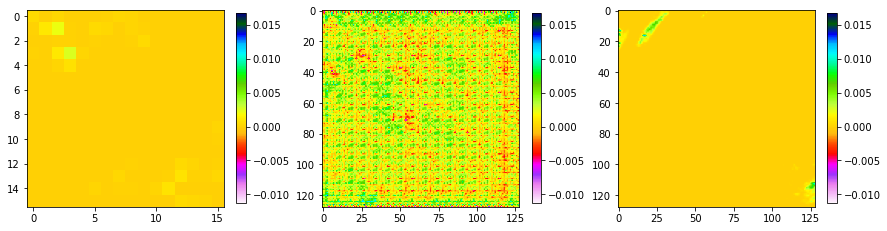

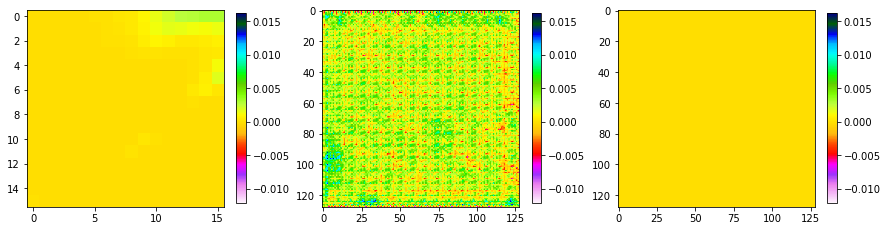

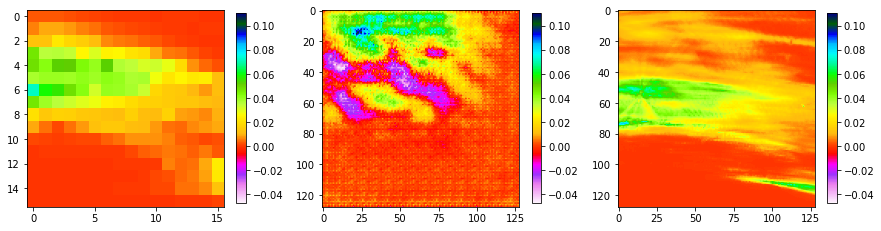

In [39]:
X, y = next(iter(dl_valid))
for i in range(5):
    plot_sample(X, y, gen, i)